In [1]:
import numpy as np
import torch
import random
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv



In [3]:
REL_POS_FOLLOWER1 = [-5, 5]
REL_POS_FOLLOWER2 = [-5, -5]

# 드론 클래스 정의
class Drone:
    def __init__(self, position, is_leader=False):
        self.position = np.array(position, dtype=np.float32)
        self.is_leader = is_leader
        self.orientation = np.array([1, 0, 0], dtype=np.float32)  # 초기 방향 (단위 벡터)

    def update_position(self, velocity):
        self.position += velocity

    def get_relative_distance_and_direction(self, other_drone):
        relative_position = other_drone.position - self.position
        distance = np.linalg.norm(relative_position).astype(np.float32)
        direction = relative_position / distance  # 정규화된 방향 벡터
        relative_direction = np.dot(self._rotation_matrix(), direction).astype(np.float32)
        return distance, relative_direction

    def _rotation_matrix(self):
        angle = np.arctan2(self.orientation[1], self.orientation[0]).astype(np.float32)
        cos_angle = np.cos(angle)
        sin_angle = np.sin(angle)
        return np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]], dtype=np.float32)

    def set_orientation(self, new_orientation):
        self.orientation = np.array(new_orientation, dtype=np.float32) / np.linalg.norm(new_orientation)




In [4]:
# 환경 정의
class DroneFormationEnv(gym.Env):
    def __init__(self):
        super(DroneFormationEnv, self).__init__()
        self.leader = Drone([0.0, 0.0], is_leader=True)
        self.follower1 = Drone(REL_POS_FOLLOWER1)
        self.follower2 = Drone(REL_POS_FOLLOWER2)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)
        self.max_steps = 100
        self.current_step = 0
    
    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.leader.position = np.array([0.0, 0.0], dtype=np.float32)
        self.follower1.position = np.array(REL_POS_FOLLOWER1, dtype=np.float32)
        self.follower2.position = np.array(REL_POS_FOLLOWER2, dtype=np.float32)
        self.current_step = 0
        random_angle = random.uniform(-np.pi, np.pi)
        self.leader.orientation = np.array([np.cos(random_angle), np.sin(random_angle)], dtype=np.float32)
        self.leader_velocity = random.uniform(0.5, 5.0)
        
        # Return both the observation and an empty info dict
        return self._get_observation(), {}

    def _get_observation(self):
        distance1, direction1 = self.follower1.get_relative_distance_and_direction(self.leader)
        distance2, direction2 = self.follower2.get_relative_distance_and_direction(self.leader)
        return np.concatenate([[distance1], direction1, [distance2], direction2]).astype(np.float32)

    def step(self, action):
        velocity_f1 = action[:2]
        velocity_f2 = action[2:4]
        self.follower1.update_position(velocity_f1)
        self.follower2.update_position(velocity_f2)
        if self.current_step % 200 == 0:
            random_angle = random.uniform(-np.pi, np.pi)
            random_speed = random.uniform(0.5, 2.0)
            self.leader.orientation = np.array([np.cos(random_angle), np.sin(random_angle)], dtype=np.float32)
            self.leader_velocity = random_speed
        leader_velocity = self.leader.orientation * self.leader_velocity
        self.leader.update_position(leader_velocity)
        reward = float(self._compute_reward())
        terminated = self._check_done()
        self.current_step += 1
        truncated = self.current_step >= self.max_steps
        return self._get_observation(), reward, terminated, truncated, {}

    def _compute_reward(self):
            if self._check_collision() or self._check_drift():
                return -100
            original_target_follower1 = np.array(REL_POS_FOLLOWER1, dtype=np.float32)
            original_target_follower2 = np.array(REL_POS_FOLLOWER2, dtype=np.float32)
            rotation_matrix = self.leader._rotation_matrix()
            rotated_target_follower1 = np.dot(rotation_matrix, original_target_follower1)
            rotated_target_follower2 = np.dot(rotation_matrix, original_target_follower2)
            global_target_follower1 = self.leader.position + rotated_target_follower1
            global_target_follower2 = self.leader.position + rotated_target_follower2
            distance_follower1 = np.linalg.norm(self.follower1.position - global_target_follower1)
            distance_follower2 = np.linalg.norm(self.follower2.position - global_target_follower2)
            return - (distance_follower1 + distance_follower2)

    def _check_collision(self):
        distance_between_leader_and_follower1 = np.linalg.norm(self.leader.position - self.follower1.position)
        distance_between_leader_and_follower2 = np.linalg.norm(self.leader.position - self.follower2.position)
        distance_between_followers = np.linalg.norm(self.follower1.position - self.follower2.position)
        if distance_between_followers < 2 or distance_between_leader_and_follower1 < 2 or distance_between_leader_and_follower2 < 2:
            return True
        else:
            return False

    def _check_drift(self):
        distance_between_leader_and_follower1 = np.linalg.norm(self.leader.position - self.follower1.position)
        distance_between_leader_and_follower2 = np.linalg.norm(self.leader.position - self.follower2.position)

        if distance_between_leader_and_follower2 > 10 or distance_between_leader_and_follower1 > 10:
            return True
        else:
            return False


    def _check_done(self):
        return self._check_collision()



Using cuda device
------------------------------
| time/              |       |
|    fps             | 5756  |
|    iterations      | 1     |
|    time_elapsed    | 5     |
|    total_timesteps | 32768 |
------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 4845           |
|    iterations           | 2              |
|    time_elapsed         | 13             |
|    total_timesteps      | 65536          |
| train/                  |                |
|    approx_kl            | 0.0045716      |
|    clip_fraction        | 0.0289         |
|    clip_range           | 0.2            |
|    entropy_loss         | -5.68          |
|    explained_variance   | -0.00035214424 |
|    learning_rate        | 0.00025        |
|    loss                 | 9.97e+05       |
|    n_updates            | 10             |
|    policy_gradient_loss | -0.00327       |
|    std                  | 1              |


c:\Users\PKNU\anaconda3\envs\me\lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'drone' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")
C:\Users\PKNU\AppData\Local\Temp\ipykernel_1896\3124736491.py:92: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, init_func=init, blit=True, repeat=False)


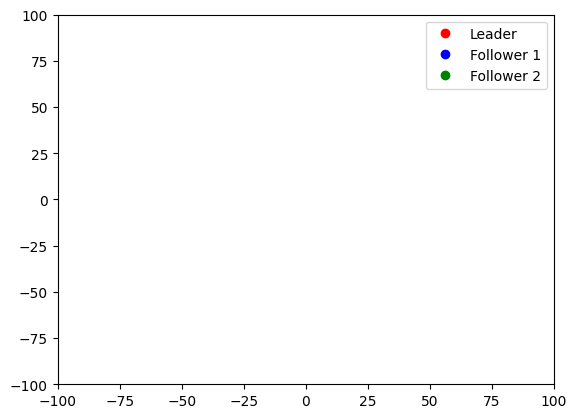

In [5]:
# 환경 생성
def make_env(env_id: str, rank: int, seed: int = 0):
    def _init():
        # return DroneFormationEnv()
        
        env = DroneFormationEnv()
        env.reset(seed=seed + rank)
        return env
    return _init

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_envs = 8
    env = SubprocVecEnv([make_env(f"DroneFormationEnv_{i}", i) for i in range(num_envs)])
    
    model = PPO(
        "MlpPolicy", 
        env, 
        verbose=1, 
        device="cuda" if torch.cuda.is_available() else "cpu", 
        # n_steps=2048, 
        # batch_size=512, 
        n_steps=4096, 
        batch_size=1024, 
        n_epochs=10, 
        gae_lambda=0.95, 
        gamma=0.99, 
        ent_coef=0.01, 
        learning_rate=2.5e-4, 
        vf_coef=0.5
    )

    obs = env.reset()

    model.learn(total_timesteps=100000)                                   ## total timestemps

    # 학습한 모델 저장
    model.save("drone/drone06_model")

    # GUI용 matplotlib 설정
    fig, ax = plt.subplots()
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)

    leader_point, = ax.plot([], [], 'ro', label='Leader')
    follower1_point, = ax.plot([], [], 'bo', label='Follower 1')
    follower2_point, = ax.plot([], [], 'go', label='Follower 2')

    def init():
        leader_point.set_data([], [])
        follower1_point.set_data([], [])
        follower2_point.set_data([], [])
        return leader_point, follower1_point, follower2_point

    def update(frame):
        global obs
        # Predict actions for all environments
        actions, _states = model.predict(obs, deterministic=True)

        # Step all environments and get the results
        obs, rewards, dones, infos = env.step(actions)

        # Merge observations
        average_observation = np.mean(obs, axis=0)

        # Merge rewards
        total_reward = np.sum(rewards)    # Sum rewards across environments
        average_reward = np.mean(rewards)  # Average rewards across environments

        # Merge episode information (if available in info dicts)
        episode_lengths = [info.get('episode_length', 0) for info in infos]
        average_episode_length = np.mean(episode_lengths)
        
        #check obs
        print(obs)

        # Update plot based on one environment's data (e.g., environment 0)
        leader_pos = obs[0, :2]  # Example of extracting leader position from first environment
        follower1_pos = obs[0, 2:4]  # Example of extracting follower 1 position
        follower2_pos = obs[0, 4:6]  # Example of extracting follower 2 position                ## 6:8

        leader_point.set_data([leader_pos[0]], [leader_pos[1]])
        follower1_point.set_data([follower1_pos[0]], [follower1_pos[1]])
        follower2_point.set_data([follower2_pos[0]], [follower2_pos[1]])

        # Reset environment if any of the environments are done
        if np.any(dones):
            obs = env.reset()

        return leader_point, follower1_point, follower2_point

    ani = FuncAnimation(fig, update, init_func=init, blit=True, repeat=False)
    plt.legend()
    plt.show()

    env.close()